In [1]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings; warnings.filterwarnings('ignore')
import cv2
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

from pylab import rcParams
rcParams['figure.figsize'] = 20,5

In [2]:
# Load metadata
train_meta = pd.read_csv('train_meta.csv', index_col=0)
valid_meta = pd.read_csv('valid_meta.csv',index_col=0)
test_meta = pd.read_csv('test_meta.csv',index_col=0)

In [3]:

train_signal = pd.read_csv('train_signal.csv')


valid_signal = pd.read_csv('valid_signal.csv')


test_signal = pd.read_csv('test_signal.csv')

In [4]:
# train_meta
# only take age sex NORM MI STTC HYP CD in df train_meta 
selected_columns = ['age', 'sex', 'NORM', 'MI', 'STTC', 'HYP', 'CD']
train_meta1 = train_meta[selected_columns]
valid_meta1 = valid_meta[selected_columns]
test_meta1 = test_meta[selected_columns]


In [5]:
train_meta1

,age,sex,NORM,MI,STTC,HYP,CD
ecg_id,,,,,,,
1,56.0,1,1,0,0,0,0
2,19.0,0,1,0,0,0,0
3,37.0,1,1,0,0,0,0
4,24.0,0,1,0,0,0,0
5,19.0,1,1,0,0,0,0
...,...,...,...,...,...,...,...
21832,63.0,0,0,0,0,0,1
21833,67.0,1,0,0,1,0,0
21834,93.0,0,1,0,0,0,0


In [6]:
valid_meta1

,age,sex,NORM,MI,STTC,HYP,CD
ecg_id,,,,,,,
8,48.0,0,0,1,0,0,0
10,22.0,1,1,0,0,0,0
17,56.0,0,0,0,0,0,0
18,56.0,0,0,0,0,0,0
20,56.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
21777,54.0,0,1,0,0,0,0
21788,72.0,1,0,1,0,0,0
21817,66.0,0,0,0,0,0,0


In [7]:
test_meta1

,age,sex,NORM,MI,STTC,HYP,CD
ecg_id,,,,,,,
9,55.0,0,1,0,0,0,0
38,40.0,0,1,0,0,0,0
40,60.0,0,1,0,0,0,0
57,26.0,0,1,0,0,0,0
59,54.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
21809,69.0,1,1,0,0,0,0
21812,67.0,0,0,0,0,0,1
21818,84.0,1,1,0,0,0,0


In [8]:
train_signal.head()

,ecg_id,channel-0,channel-1,channel-2,channel-3,channel-4,channel-5,channel-6,channel-7,channel-8,channel-9,channel-10,channel-11
0,1,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079
1,1,-0.116,-0.051,0.065,0.083,-0.090,0.006,-0.064,-0.036,-0.003,-0.031,-0.034,-0.074
2,1,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069
3,1,-0.117,-0.038,0.080,0.077,-0.098,0.021,-0.050,-0.030,-0.015,-0.023,-0.022,-0.064
4,1,-0.103,-0.031,0.072,0.066,-0.087,0.021,-0.045,-0.027,-0.020,-0.019,-0.018,-0.058


In [9]:
class PTBXLDatasetPreprocesser():
    def __init__(self):
        pass
    
    def save(self, filename):
        data = {
            'superclass_cols': self.superclass_cols,
            'meta_num_cols': self.meta_num_cols,
            'meta_num_means': self.meta_num_means,
            'min_max_scaler': self.min_max_scaler,
            'meta_cat_cols': self.meta_cat_cols,
            'cat_lablers': self.cat_lablers,
        }
        pd.to_pickle(data, filename)
        
    def load(self, filename):
        data = pd.read_pickle(filename)
        self.min_max_scaler = data['min_max_scaler']
        self.cat_lablers = data['cat_lablers']
        
    def fit(self, x, y):
        x = x.copy()
        y = y.copy()
        
        self.superclass_cols = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
        
    
        
        self.meta_num_cols = ['age']
        self.meta_num_means = []
        for col in self.meta_num_cols:
            print(col, y[col].mean())
            y[col] = y[col].fillna(y[col].mean())
            self.meta_num_means += [y[col].mean()]
            
        self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])
        
        self.meta_cat_cols = ['sex'] #, 'nurse', 'device']
        self.cat_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_cat_cols]
        return self
    
    def transform(self, x, y):
        
        channel_cols = x.columns.tolist()[1:]
        
        ret = []
        x = x[channel_cols].values.reshape(-1, 1000, 12)
        print(x.shape)
        ret += [x] # signal
        
        y_ = y.copy()
        
        for i, col in enumerate(self.meta_num_cols):
            y_[col] = y_[col].fillna(self.meta_num_means[i])
        y_[self.meta_num_cols] = self.min_max_scaler.transform(y_[self.meta_num_cols])
        y_[self.meta_num_cols] = np.clip(y_[self.meta_num_cols], 0., 1.) # prevent extreme value far from train set
        
        ret += [y_[self.meta_num_cols]] # meta num features
        
        for i, col in enumerate(self.meta_cat_cols):
            y_[col] = y_[col].fillna('none').astype(str)
            y_[col] = self.cat_lablers[i].transform(y_[col]) 
        
        ret += [y_[self.meta_cat_cols]] # meta cat features
        
        if np.isin(self.superclass_cols, y.columns).sum() == len(self.superclass_cols):
            ret += [y[self.superclass_cols].fillna(0).astype(int)] # superclass targets
        
        
        return ret

In [10]:
data_preprocessor = PTBXLDatasetPreprocesser()
data_preprocessor.fit(train_signal, train_meta1)
train_signal, train_meta_num_feats, train_meta_cat_feats, train_superclass = data_preprocessor.transform(train_signal, train_meta1)
valid_signal, valid_meta_num_feats, valid_meta_cat_feats, valid_superclass = data_preprocessor.transform(valid_signal, valid_meta1)
test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass = data_preprocessor.transform(test_signal, test_meta1)

print(train_signal.shape)
print(valid_meta_num_feats.isna().sum(), valid_meta_cat_feats.isna().sum(), valid_superclass.isna().sum())

display(train_meta_num_feats)
display(train_meta_cat_feats)
display(train_superclass)

age 59.63709074169975
(17441, 1000, 12)
(2193, 1000, 12)
(2203, 1000, 12)
(17441, 1000, 12)
age    0
dtype: int64 sex    0
dtype: int64 NORM    0
MI      0
STTC    0
CD      0
HYP     0
dtype: int64


,age
ecg_id,
1,0.580645
2,0.182796
3,0.376344
4,0.236559
5,0.182796
...,...
21832,0.655914
21833,0.698925
21834,0.978495


,sex
ecg_id,
1,1
2,0
3,1
4,0
5,1
...,...
21832,0
21833,1
21834,0


,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21832,0,0,0,1,0
21833,0,0,1,0,0
21834,1,0,0,0,0


In [11]:
train_signal[0, 0, :]

array([-0.119, -0.055,  0.064,  0.086, -0.091,  0.004, -0.069, -0.031,
        0.   , -0.026, -0.039, -0.079])

In [12]:
data_preprocessor.save('data_preprocessor.pkl')

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [14]:
class ECGDataset(Dataset):
    def __init__(self, signals, num_metas, cat_metas, superclass_labels=None):
        self.signals = signals
        self.num_metas = num_metas
        self.cat_metas = cat_metas
        self.superclass_labels = superclass_labels
        
    def __len__(self):
        return self.signals.shape[0]
    
    def __getitem__(self, idx):
        
        ret = []
        ret += [self.signals[idx,:]]
        ret += [self.num_metas.values[idx,:]]
        ret += [self.cat_metas.values[idx,:]]
        
        if self.superclass_labels is not None:
            ret += [self.superclass_labels.values[idx,:]]
        
    
        
        return ret

In [13]:
class ECGClassifier(nn.Module):
    def __init__(self, signal_channel_size, gru_hidden_size, per_cat_nunique, embed_size, num_size, hidden, n_outs):
        super().__init__()
        
        self.gru1 = nn.GRU(signal_channel_size, gru_hidden_size, batch_first=True, bidirectional=True)
        #self.lstm2 = nn.LSTM(gru_hidden_size*2, gru_hidden_size, batch_first=True, bidirectional=True)
        
        self.embeds = []
        self.per_cat_nunique = per_cat_nunique
        for v in self.per_cat_nunique:
            self.embeds += [nn.Embedding(v, embed_size)]
        self.embeds = nn.ModuleList(self.embeds)
        
        self.dense1 = nn.Linear(gru_hidden_size*4 + embed_size*len(per_cat_nunique) + num_size, hidden)
        self.relu = nn.ReLU()
        self.out = nn.Linear(hidden, n_outs)
        
    def forward(self, signal, num_meta, cat_meta):
        #print(signal.shape)
        signal = signal.view(signal.shape[0], signal.shape[1], -1)
        #print(signal.shape)
        signal, _ = self.gru1(signal)
        #signal, _ = self.lstm2(signal)
        
        avg_pool = torch.mean(signal, 1)
        max_pool, _ = torch.max(signal, 1)
        
        cat_feats = []
        for i, embed in enumerate(self.embeds):
            cat_feats += [embed(cat_meta[:,i].long())]
        cat_feats = torch.cat(cat_feats, 1) 
        
        x = torch.cat([avg_pool, max_pool, cat_feats, num_meta], 1)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.out(x)
        
        return x

In [16]:
def prepare_dataloader(signal, meta_num_feats, meta_cat_feats, superclass, num_workers=0):
    
    ds = ECGDataset(signal, meta_num_feats, meta_cat_feats, superclass_labels=superclass)
    
    dl = torch.utils.data.DataLoader(
        ds,
        batch_size=128,
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=num_workers,
        #sampler=BalanceClassSampler(labels=y_train, mode='downsampling'),
    )
    return dl

def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (signal, num_meta, cat_meta, superclass_labels) in pbar:
        signal = signal.to(device).float()
        num_meta = num_meta.to(device).float()
        cat_meta = cat_meta.to(device).long()
        
        superclass_labels = superclass_labels.to(device).long()
        labels = torch.cat([superclass_labels], 1).float()
        
        #print(image_labels.shape, exam_label.shape)
        with autocast():
            preds = model(signal, num_meta, cat_meta)   #output = model(input)
            #print(image_preds.shape, exam_pred.shape)

            #print(preds, labels)
            loss = loss_fn(preds, labels)
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad() 

        if scheduler is not None and schd_batch_update:
            scheduler.step()

        description = f'epoch {epoch} loss: {running_loss:.4f}'

        pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    preds_all = []
    targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (signal, num_meta, cat_meta, superclass_labels) in pbar:
        signal = signal.to(device).float()
        num_meta = num_meta.to(device).float()
        cat_meta = cat_meta.to(device).long()
        
        superclass_labels = superclass_labels.to(device)

        labels = torch.cat([superclass_labels], 1).float()
        
        preds = model(signal, num_meta, cat_meta)   #output = model(input)
        
        preds_all += [preds.detach().cpu().numpy()]
        targets_all += [labels.detach().cpu().numpy()]
        
        loss = loss_fn(preds, labels)
        
        loss_sum += loss.item()*labels.shape[0]
        sample_num += labels.shape[0]  

        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)
    
    preds_all = np.concatenate(preds_all)
    targets_all = np.concatenate(targets_all)
    superclass_cnt = superclass_labels.shape[1]
    print('validation superclass multi-label acc = {:.4f}'.format((targets_all[:,:superclass_cnt]==(preds_all[:,:superclass_cnt] >= 0.5)).mean()))
    print('validation superclass multi-label auc = {:.4f}'.format(roc_auc_score(targets_all[:,:superclass_cnt], preds_all[:,:superclass_cnt], average='macro')))
    print('validation multi-label acc = {:.4f}'.format((targets_all==(preds_all >= 0.5)).mean()))
    print('validation multi-label auc = {:.4f}'.format(roc_auc_score(targets_all, preds_all, average='macro')))
    
    if scheduler is not None:
         if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
         else:
            scheduler.step()
            
    return targets_all, preds_all

In [17]:
if __name__ == '__main__':
    # for training only, need nightly build pytorch

    seed = 719
    epochs = 6
    stepsize= 2
    hidden_sie = 64
    seed_everything(719)
    
    
    train_loader = prepare_dataloader(train_signal, train_meta_num_feats, train_meta_cat_feats, train_superclass,num_workers=0,)
    val_loader = prepare_dataloader(valid_signal, valid_meta_num_feats, valid_meta_cat_feats, valid_superclass,num_workers=0)
    
    #test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass = data_preprocessor.transform(test_signal, test_df)

    device = torch.device('cpu')

    per_cat_nunique = [len(labeler.classes_) for labeler in data_preprocessor.cat_lablers]
    model = ECGClassifier(train_signal.shape[2], 128, per_cat_nunique, 30, train_meta_num_feats.shape[1], 128, 
                          train_superclass.shape[1]).to(device)
    scaler = GradScaler()   
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=stepsize)

    loss_tr = nn.BCEWithLogitsLoss().to(device)
    loss_fn = nn.BCEWithLogitsLoss().to(device)

    for epoch in range(epochs):
        train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

        with torch.no_grad():
            val_targets, val_preds = valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

    torch.save(model.state_dict(),'pytorch_ecg_rnn.pth')

    #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
    del model, optimizer, train_loader, val_loader, scaler, scheduler
    torch.cuda.empty_cache()

epoch 0 loss: 0.3514: 100%|██████████| 18/18 [01:00<00:00,  3.34s/it]


validation superclass multi-label acc = 0.8434
validation superclass multi-label auc = 0.8877
validation multi-label acc = 0.8434
validation multi-label auc = 0.8877


epoch 1 loss: 0.3447: 100%|██████████| 18/18 [01:02<00:00,  3.48s/it]


validation superclass multi-label acc = 0.8455
validation superclass multi-label auc = 0.9021
validation multi-label acc = 0.8455
validation multi-label auc = 0.9021


epoch 2 loss: 0.2908: 100%|██████████| 18/18 [01:04<00:00,  3.61s/it]


validation superclass multi-label acc = 0.8738
validation superclass multi-label auc = 0.9152
validation multi-label acc = 0.8738
validation multi-label auc = 0.9152


epoch 3 loss: 0.2871: 100%|██████████| 18/18 [00:58<00:00,  3.27s/it]


validation superclass multi-label acc = 0.8788
validation superclass multi-label auc = 0.9174
validation multi-label acc = 0.8788
validation multi-label auc = 0.9174


epoch 4 loss: 0.2871: 100%|██████████| 18/18 [01:00<00:00,  3.35s/it]


validation superclass multi-label acc = 0.8764
validation superclass multi-label auc = 0.9173
validation multi-label acc = 0.8764
validation multi-label auc = 0.9173


epoch 5 loss: 0.2871: 100%|██████████| 18/18 [00:58<00:00,  3.27s/it]

validation superclass multi-label acc = 0.8772
validation superclass multi-label auc = 0.9175
validation multi-label acc = 0.8772
validation multi-label auc = 0.9175


In [18]:
def predict(data_preprocessor, test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass):
    tst_loader = prepare_dataloader(test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass)
    
    device = torch.device('cpu')
    per_cat_nunique = [len(labeler.classes_) for labeler in data_preprocessor.cat_lablers]
    model = ECGClassifier(train_signal.shape[2], 128, per_cat_nunique, 30, train_meta_num_feats.shape[1], 128, 
                          train_superclass.shape[1]).to(device)
    model.load_state_dict(torch.load('pytorch_ecg_rnn.pth', map_location='cpu'))
    
    preds_all = []
    targets_all = []
    pbar = tqdm(enumerate(tst_loader), total=len(tst_loader))
    for step, (signal, num_meta, cat_meta, superclass_labels) in pbar:
        signal = signal.to(device).float()
        num_meta = num_meta.to(device).float()
        cat_meta = cat_meta.to(device).long()
        
        superclass_labels = superclass_labels.to(device)
    
        labels = torch.cat([superclass_labels], 1).float()
        
        preds = model(signal, num_meta, cat_meta)   #output = model(input)
        
        preds_all += [preds.detach().cpu().numpy()]
        targets_all += [labels.detach().cpu().numpy()]
    
    
    preds_all = np.concatenate(preds_all)
    targets_all = np.concatenate(targets_all)
    superclass_cnt = superclass_labels.shape[1]
    print('test superclass multi-label acc = {:.4f}'.format((targets_all[:,:superclass_cnt]==(preds_all[:,:superclass_cnt] >= 0.5)).mean()))
    print('test superclass multi-label auc = {:.4f}'.format(roc_auc_score(targets_all[:,:superclass_cnt], preds_all[:,:superclass_cnt], average='macro')))
    print('test multi-label acc = {:.4f}'.format((targets_all==(preds_all >= 0.5)).mean()))
    print('test multi-label auc = {:.4f}'.format(roc_auc_score(targets_all, preds_all, average='macro')))
    
    return preds_all, targets_all
    
test_prob_preds, test_labels = predict(data_preprocessor, test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass)
test_pred = (test_prob_preds>=0.5).astype(int)

100%|██████████| 18/18 [01:11<00:00,  3.98s/it]

test superclass multi-label acc = 0.8782
test superclass multi-label auc = 0.9128
test multi-label acc = 0.8782
test multi-label auc = 0.9128


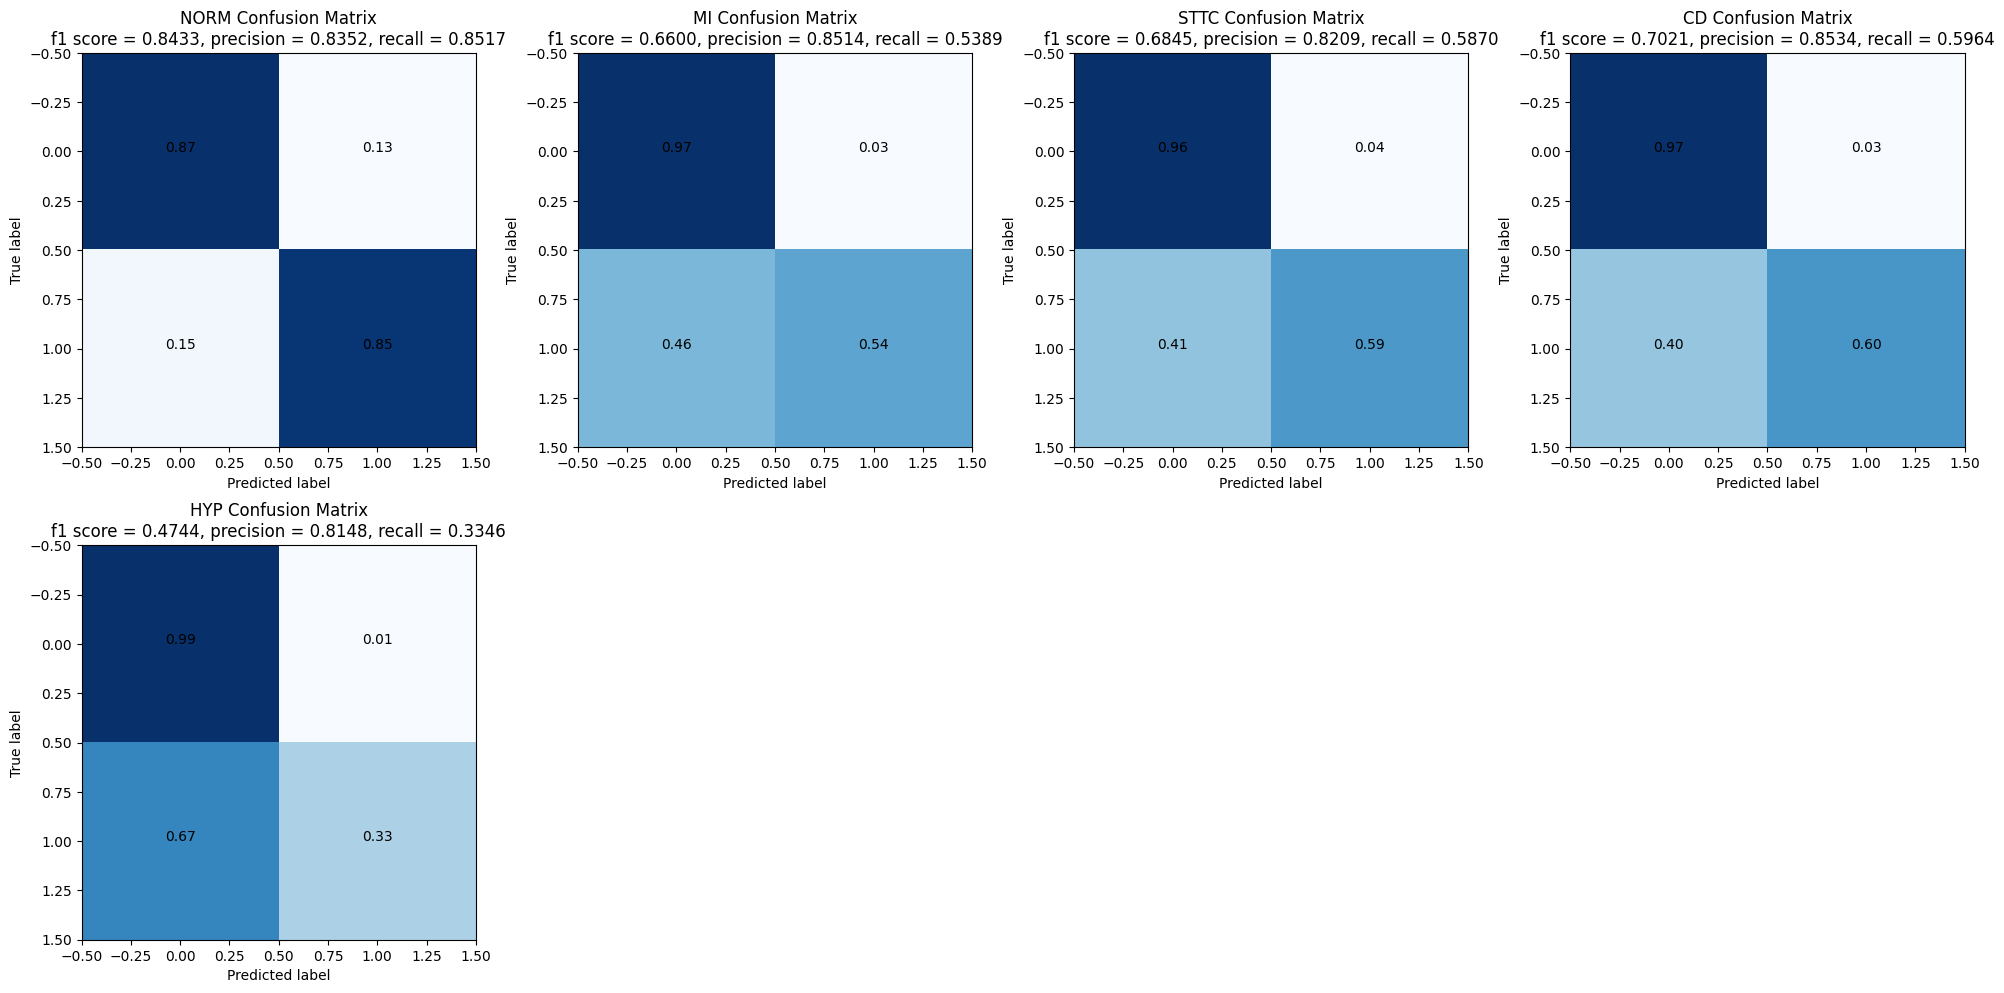

In [19]:
from sklearn.metrics import precision_score, recall_score

# Only take the first 5 classes
cols = list(data_preprocessor.superclass_cols)[:5]
n_rows = int(np.ceil(len(cols)/4))
fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5*n_rows))

for i, col in enumerate(cols):
    
    ax = axes[int(np.floor(i/4)), i%4]
    cm = confusion_matrix(test_labels[:, i], test_pred[:, i])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fls = f1_score(test_labels[:, i], test_pred[:, i])
    precision = precision_score(test_labels[:, i], test_pred[:, i])
    recall = recall_score(test_labels[:, i], test_pred[:, i])
    
    ax.set_title('{} Confusion Matrix\nf1 score = {:.4f}, precision = {:.4f}, recall = {:.4f}'.format(col, fls, precision, recall))
    
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="black")

    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# Remove empty subplots
if len(cols) % 4 != 0:
    for ax in axes.flatten()[len(cols):]:
        fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [42]:
def predict_single_instance(data_preprocessor, signal_instance, num_meta_instance, cat_meta_instance):
    device = torch.device('cpu')
    per_cat_nunique = [len(labeler.classes_) for labeler in data_preprocessor.cat_lablers]
    model = ECGClassifier(train_signal.shape[2], 128, per_cat_nunique, 30, train_meta_num_feats.shape[1], 128, 
                          train_superclass.shape[1]).to(device)
    model.load_state_dict(torch.load('pytorch_ecg_rnn.pth', map_location='cpu'))
    model.eval()
    
    signal_instance = torch.tensor(signal_instance).unsqueeze(0).float().to(device)
    num_meta_instance = torch.tensor(num_meta_instance).unsqueeze(0).float().to(device)
    cat_meta_instance = torch.tensor(cat_meta_instance).unsqueeze(0).long().to(device)
    
    with torch.no_grad():
        pred = model(signal_instance, num_meta_instance, cat_meta_instance)
        pred = torch.sigmoid(pred).cpu().numpy()
    
    return pred

# Example usage:
signal_instance = train_signal[0]
num_meta_instance = train_meta_num_feats.iloc[0].values
cat_meta_instance = train_meta_cat_feats.iloc[0].values

prediction = predict_single_instance(data_preprocessor, signal_instance, num_meta_instance, cat_meta_instance)
print("Prediction:", prediction)

Prediction: [[9.79401469e-01 3.32578947e-03 9.45939682e-03 1.32034235e-02
  4.69850376e-04]]


In [43]:
# Extract and print superclass labels for a given instance#
def extract_superclass_labels(instance):
    superclass_cols = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
    superclass_labels = instance[2]
    superclass_labels = pd.Series(superclass_labels, index=superclass_cols)
    return superclass_labels


In [44]:
# Predict on a single instance
signal_instance = train_signal[0]
num_meta_instance = train_meta_num_feats.iloc[0].values
cat_meta_instance = train_meta_cat_feats.iloc[0].values

prediction = predict_single_instance(data_preprocessor, signal_instance, num_meta_instance, cat_meta_instance)

# Convert prediction probabilities to superclass labels
superclass_labels = (prediction >= 0.5).astype(int)

# Map the predicted labels to their corresponding class names
class_names = data_preprocessor.superclass_cols
predicted_classes = [class_names[i] for i in range(len(class_names)) if superclass_labels[0][i] == 1]

print("Prediction Probabilities:", prediction)
print("Superclass Labels:", superclass_labels)
print("Predicted Classes:", predicted_classes)

Prediction Probabilities: [[9.79401469e-01 3.32578947e-03 9.45939682e-03 1.32034235e-02
  4.69850376e-04]]
Superclass Labels: [[1 0 0 0 0]]
Predicted Classes: ['NORM']


In [17]:
# Predict on a single instance
signal_instance = test_signal[86]
num_meta_instance = test_meta_num_feats.iloc[86].values
cat_meta_instance = test_meta_cat_feats.iloc[86].values

prediction = predict_single_instance(data_preprocessor, signal_instance, num_meta_instance, cat_meta_instance)

# Convert prediction probabilities to superclass labels
superclass_labels = (prediction >= 0.5).astype(int)

print("Prediction Probabilities:", prediction)
print("Superclass Labels:", superclass_labels)

Prediction Probabilities: [[0.00429243 0.42541358 0.3815587  0.7611762  0.20848124]]
Superclass Labels: [[0 0 0 1 0]]


In [18]:
import pandas as pd
import numpy as np
import os
import wfdb
import ast
import ecg_plot
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

In [19]:
def create_file_dataframe(path):
    filenames = [f for f in os.listdir(path) if f.endswith('.dat')]
    df = pd.DataFrame({
        'filename_lr': filenames,  # Assuming all files in your case are low-resolution (lr)
    })
    return df

In [20]:
# Load raw ECG data
def load_raw_data(df, sampling_rate, path):
    data = []
    for f in tqdm(df['filename_lr'] if sampling_rate == 100 else df['filename_hr']):
        # Load the record from the .dat file
        record = wfdb.rdrecord(os.path.join(path, f.split('.')[0]))
        data.append(record.p_signal)  # Extract the 12-lead ECG signal
    data = np.array(data)
    return data

In [21]:
# Define the path to the data folder
path = 'D:\\Semester 7\\FYP\\Data'

# Create the dataframe with filenames
df = create_file_dataframe(path)

# Set the sampling rate
sampling_rate = 100

# Load the ECG data
X = load_raw_data(df, sampling_rate, path)

# Check the shape of the data (should be in the form of samples, timesteps, leads)
print('Data shape:', X.shape)

100%|██████████| 1/1 [00:00<00:00, 98.64it/s]

Data shape: (1, 1000, 12)


In [22]:
# create data frame of X write channels instead of 


X_df = pd.DataFrame(X[0], columns=['channel-1', 'channel-2', 'channel-3', 'channel-4', 'channel-5', 'channel-6', 'channel-7', 'channel-8', 'channel-9', 'channel-10', 'channel-11', 'channel-12'])

In [23]:
X_df.head()

,channel-1,channel-2,channel-3,channel-4,channel-5,channel-6,channel-7,channel-8,channel-9,channel-10,channel-11,channel-12
0,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079
1,-0.116,-0.051,0.065,0.083,-0.090,0.006,-0.064,-0.036,-0.003,-0.031,-0.034,-0.074
2,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069
3,-0.117,-0.038,0.080,0.077,-0.098,0.021,-0.050,-0.030,-0.015,-0.023,-0.022,-0.064
4,-0.103,-0.031,0.072,0.066,-0.087,0.021,-0.045,-0.027,-0.020,-0.019,-0.018,-0.058


In [39]:
import torch
import numpy as np
import pandas as pd

# Assuming ECGClassifier and data_preprocessor are defined elsewhere
# from your_module import ECGClassifier, data_preprocessor

def predict_single_instance(data_preprocessor, signal_instance, age, gender):
    device = torch.device('cpu')
    per_cat_nunique = [len(labeler.classes_) for labeler in data_preprocessor.cat_lablers]
    model = ECGClassifier(train_signal.shape[2], 128, per_cat_nunique, 30, train_meta_num_feats.shape[1], 128, 
                          train_superclass.shape[1]).to(device)
    model.load_state_dict(torch.load('pytorch_ecg_rnn.pth', map_location='cpu'))
    model.eval()
    
    signal_instance = torch.tensor(signal_instance).unsqueeze(0).float().to(device)
    num_meta_instance = torch.tensor([age]).unsqueeze(0).float().to(device)
    cat_meta_instance = torch.tensor([gender]).unsqueeze(0).long().to(device)
    
    with torch.no_grad():
        pred = model(signal_instance, num_meta_instance, cat_meta_instance)
        pred = torch.sigmoid(pred).cpu().numpy()
    
    return pred

# Example usage:
signal_instance = train_signal[0]

# Prompt user for age and gender
age = float(input("Enter age: "))
gender = int(input("Enter gender (0 for male, 1 for female): "))

prediction = predict_single_instance(data_preprocessor, signal_instance, age, gender)
print("Prediction:", prediction)

Prediction: [[1.9717757e-18 9.9994504e-01 9.9796200e-01 7.6591510e-01 6.9710448e-05]]


In [46]:
df = pd.read_csv('D:\Semester 7\FYP\models\ptbxl_database.csv')

In [47]:
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [53]:
df_age = df['age']

In [68]:
df_age

0        56.0
1        19.0
2        37.0
3        24.0
4        19.0
         ... 
21832    67.0
21833    93.0
21834    59.0
21835    64.0
21836    68.0
Name: age, Length: 21837, dtype: float64

In [80]:
# save into csv
df_age.to_csv('age.csv', index=False)

In [82]:
import torch
import numpy as np
import pandas as pd

# Load the actual and normalized age data from CSV files
actual_age_data = pd.read_csv('age.csv')      # Actual age data

# Function to normalize the user-entered age using actual age data
def normalize_age(user_age, actual_age_data):
    min_age = actual_age_data['age'].min()  # Assuming 'age' is the column name
    max_age = actual_age_data['age'].max()
    
    # Normalize the age
    normalized = (user_age - min_age) / (max_age - min_age)

    
    return normalized  # Return normalized value

# Your existing function
def predict_single_instance(data_preprocessor, X_df, age, gender):
    # Setup device
    device = torch.device('cpu')  # Ensure CPU compatibility

    # Get the number of unique categories for each categorical label
    per_cat_nunique = [len(labeler.classes_) for labeler in data_preprocessor.cat_lablers]

    # Initialize the model with appropriate input dimensions
    model = ECGClassifier(X_df.shape[1], 128, per_cat_nunique, 30, 1, 128, 5).to(device)

    # Load pre-trained model weights
    model.load_state_dict(torch.load('pytorch_ecg_rnn.pth', map_location='cpu'))
    model.eval()  # Set model to evaluation mode

    # Prepare data for the model
    signal_instance = torch.tensor(X_df.values).unsqueeze(0).float().to(device)
    num_meta_instance = torch.tensor([age]).unsqueeze(0).float().to(device)
    cat_meta_instance = torch.tensor([gender]).unsqueeze(0).long().to(device)

    # Make prediction
    with torch.no_grad():
        pred = model(signal_instance, num_meta_instance, cat_meta_instance)
        pred = torch.sigmoid(pred).cpu().numpy()  # Get probabilities with sigmoid and convert to numpy

    return pred

# Extract and print superclass labels for a given instance
def extract_superclass_labels(prediction):
    superclass_cols = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
    superclass_labels = (prediction >= 0.5).astype(int)
    superclass_labels = pd.Series(superclass_labels[0], index=superclass_cols)
    
    # Extract class names where the label is 1
    class_names = superclass_labels[superclass_labels == 1].index.tolist()
    
    return superclass_labels, class_names

# Example usage:
# Prompt user for age and gender input
age = float(input("Enter age: "))
gender = int(input("Enter gender (0 for male, 1 for female): "))

# Normalize the age using the actual age data
normalized_age = normalize_age(age, actual_age_data)



# Get the prediction for the single instance
prediction = predict_single_instance(data_preprocessor, X_df, normalized_age, gender)

# Extract and print superclass labels
superclass_labels, class_names = extract_superclass_labels(prediction)
print("Prediction Probabilities:", prediction)
print("Superclass Labels:", superclass_labels)
print("Class Names:", class_names)


Prediction Probabilities: [[9.79401469e-01 3.32578947e-03 9.45939682e-03 1.32034235e-02
  4.69850376e-04]]
Superclass Labels: NORM    1
MI      0
STTC    0
CD      0
HYP     0
dtype: int32
Class Names: ['NORM']
